# Transfer Learning with TensorFlow part 2: Fine-Tuning

 In the previous notebook, we covered transfer earning feature extraction. Now it's time to learn about a new kind of transfer learning fine tuning

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-03 07:21:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-03 07:21:08 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import hepler functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-04-03 07:21:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.5MB/s    in 8.5s    

2023-04-03 07:21:21 (19.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("10_food_classes_10_percent.zip")

In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE=(224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 87.2787     48.278698   15.278698 ]
   [ 85.838005   46.83801    13.83801  ]
   [ 86.29528    47.29528    14.29528  ]
   ...
   [ 38.08896    21.088959    3.5174856]
   [ 39.614483   22.614483    4.6144824]
   [ 39.642822   22.642822    4.6428223]]

  [[ 84.96588    48.96588    14.96588  ]
   [ 81.47226    45.47226    11.472258 ]
   [ 84.29464    48.29464    14.294642 ]
   ...
   [ 39.428528   22.428528    4.8570557]
   [ 39.08898    22.088984    4.088983 ]
   [ 41.491074   24.491072    6.4910717]]

  [[ 88.38808    54.388073   19.388073 ]
   [ 87.13743    53.137436   18.137436 ]
   [ 82.168045   48.16805    13.168049 ]
   ...
   [ 38.428528   21.428528    3.8570557]
   [ 40.142883   23.142883    5.1428833]
   [ 44.         27.          9.       ]]

  ...

  [[ 87.         60.         33.       ]
   [ 87.         60.         33.       ]
   [ 86.         59.         32.       ]
   ...
   [ 99.07       69.07       41.22173  ]
   [102.838425   73.77882    43.91971  ]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibilit with our models.

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (the underlying pre-trained patterns aren't updated during the training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50v2 you will need to normalize inputs (don't have to when using efficient net)
x = tf.keras.layers.Rescaling(1./255)(inputs)

# 5.Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model")

# 6. Average pool the outputs of the base model (aggregate all the most important niformation, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8.Combine the inputs with the outputs into the model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        steps_per_epoch=len(train_data_10_percent),
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)))

16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base model
Shape after GlobalAveragePooling2D: (None, 1280)
Epoch 1/5
24/24 [==============================] - 22s 258ms/step - loss: 1.9090 - accuracy: 0.4040 - val_loss: 1.3091 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - 4s 149ms/step - loss: 1.1190 - accuracy: 0.7507 - val_loss: 0.8664 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 4s 158ms/step - loss: 0.7941 - accuracy: 0.8293 - val_loss: 0.6967 - val_accuracy: 0.8651
Epoch 4/5
24/24 [==============================] - 4s 139ms/step - loss: 0.6395 - accuracy: 0.8533 - val_loss: 0.5852 - val_accuracy: 0.8832
Epoch 5/5
24/24 [==============================] - 5s 174ms/step - loss: 0.5499 - accuracy: 0.8773 - val_loss: 0.5331 - val_accuracy: 0.8947


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 0.5560 - accuracy: 0.8640


[0.5560498237609863, 0.8640000224113464]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [13]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

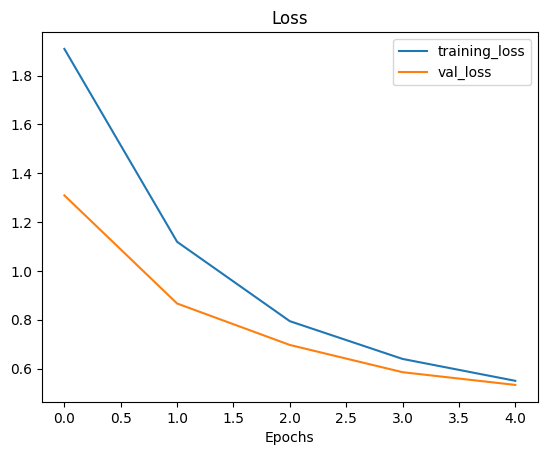

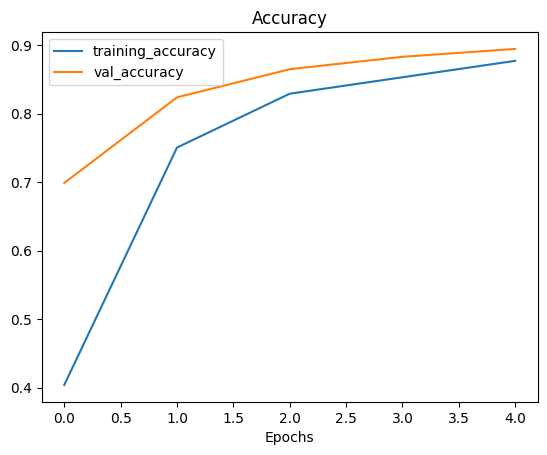

In [14]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turnd into (None, 1280).

Let's use a similar shapes tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [15]:
# Set random seed
tf.random.set_seed(42)

# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"shape of input tensor {input_tensor.shape}")
print(f"shape of global average pooled tensor {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor (1, 4, 4, 3)
shape of global average pooled tensor (1, 3)


In [16]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augumentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augumentation
3. `model_3` - use fine tuning transfer learning on 10% of the training data with data augumentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augumentation

## Getting and preprocessing data for `model_1`

In [17]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-04-03 07:22:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  22.5MB/s    in 7.1s    

2023-04-03 07:22:30 (18.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [18]:
# Create training and test dirs
train_dir_1_percent = "/content/10_food_classes_1_percent/train/"
test_dir = "/content/10_food_classes_1_percent/test/"

In [19]:
# How many images are we working with
walk_through_dir("/content/10_food_classes_1_percent")

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_1_pe

In [20]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

test_dir = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augumentation right into the model

To add data augumentation right into our models, we can use the layers inside:

* `tf.keras.layers`

We can see the benefits of doing this within the TensorFlow Data augumentation documentation

Off the top of our heads, after reading the docs, the benefits of using data augumentation inside the model are:
* Preprocessing of images (augumenting them) happens on the GPU (much faster) rather than on the CPU.
* Image data augumentation only happens during training, so we can still export our whole model and use it elsewhere

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth

# Create data augumentation stage horizontal flipping, rotations, zooms, etc
data_augumentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    # RandomRescale(1./255), # Keep for models like resnet50v2. Unnecessary for efficient net models (they have it built in)
], name="data_augumentation")



### Visualize our data augumentation layer (and see what happens to our data)

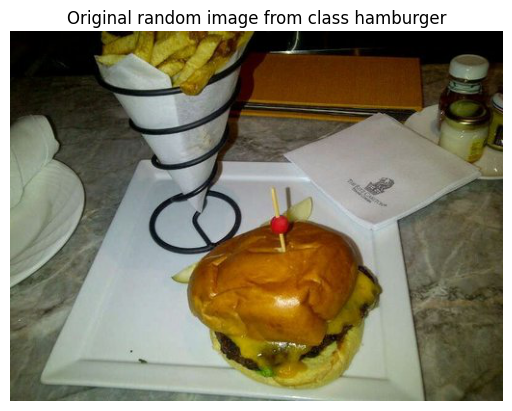

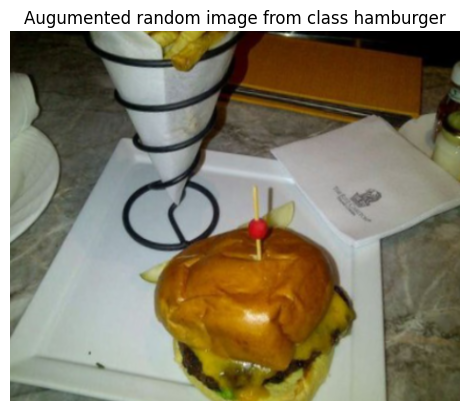

In [22]:
# View a random image and compare it to its augumented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augumented random image
augumented_img = data_augumentation(tf.expand_dims(img, axis=0))

plt.figure()
plt.imshow(tf.squeeze(augumented_img)/ 255.)
plt.title(f"Augumented random image from class {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augumentation

In [23]:
# Setup the input shape and base model, freezing the base model laeyrs
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augumentation Sequential model as a layer
x = data_augumentation(inputs)

# Give base_model the inputs (after augumentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [24]:
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                steps_per_epoch=len(train_data_1_percent),
                                epochs=5,
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230403-072235
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.4355 - accuracy: 0.1000 - val_loss: 2.1772 - val_accuracy: 0.2056
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1266 - accuracy: 0.3000 - val_loss: 2.0445 - val_accuracy: 0.3092
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9226 - accuracy: 0.4286 - val_loss: 1.9172 - val_accuracy: 0.4128
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 1.7621 - accuracy: 0.5429 - val_loss: 1.8294 - val_accuracy: 0.4737
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6030 - accuracy: 0.6571 - val_loss: 1.7363 - val_accuracy: 0.5132


In [25]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augumentation (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [26]:
# Evaluate on the full test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 1.7691 - accuracy: 0.4944


[1.7690562009811401, 0.4943999946117401]

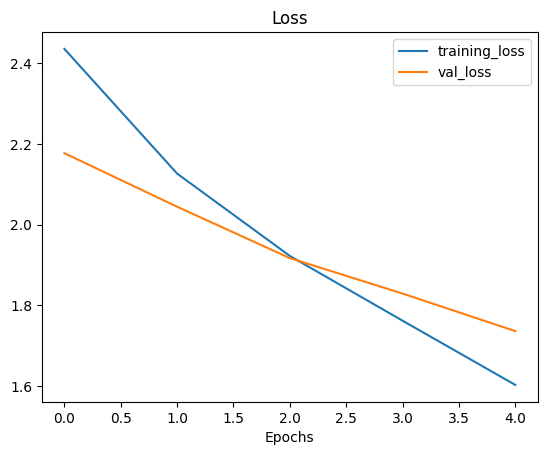

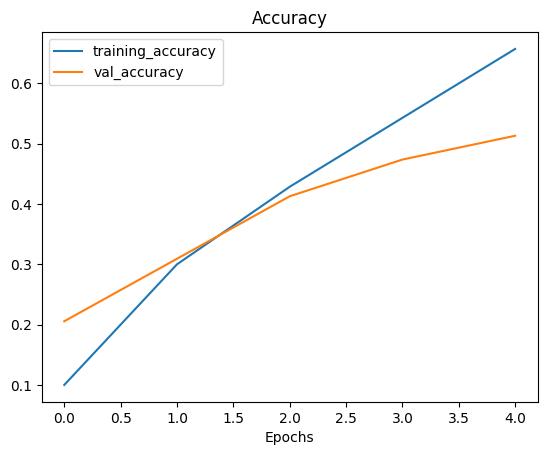

In [27]:
# How does the model with 1% of the train data go with data augumentation
plot_loss_curves(history_1_percent)

In [28]:
# Setup the input shape and base model freezing the top layers
input_shape=(224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augumentation
x = data_augumentation(inputs)

# Give base model the inputs and dont train it
x = base_model(x, training=False)

# Pool output features out of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# Put out a Dense layer as an output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2_10_percent = model_2.fit(train_data_10_percent,
                                   steps_per_epoch=len(train_data_10_percent),
                                   epochs=5,
                                   validation_data=test_data,
                                   validation_steps=int(0.25 * len(test_data)),
                                   callbacks=[create_tensorboard_callback("transfer_learning",
                                                                          "10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230403-072319
Epoch 1/5
24/24 [==============================] - 22s 611ms/step - loss: 1.9724 - accuracy: 0.3373 - val_loss: 1.4130 - val_accuracy: 0.6711
Epoch 2/5
24/24 [==============================] - 12s 491ms/step - loss: 1.3025 - accuracy: 0.7000 - val_loss: 0.9616 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - 13s 511ms/step - loss: 0.9790 - accuracy: 0.7773 - val_loss: 0.7571 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 11s 423ms/step - loss: 0.8131 - accuracy: 0.8093 - val_loss: 0.6681 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 11s 424ms/step - loss: 0.7153 - accuracy: 0.8360 - val_loss: 0.5771 - val_accuracy: 0.8717


In [29]:
# Evaluate the model
model_2.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.6152 - accuracy: 0.8420


[0.6152315735816956, 0.8420000076293945]

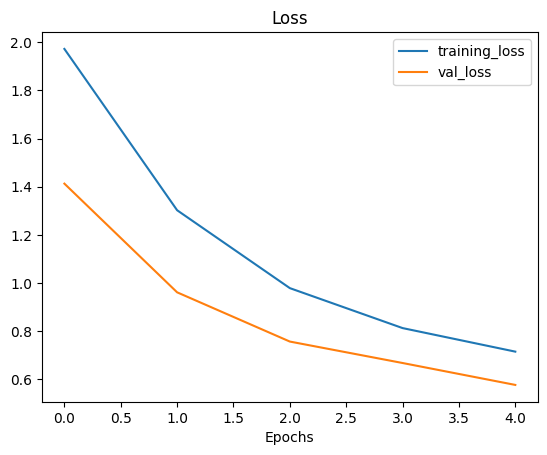

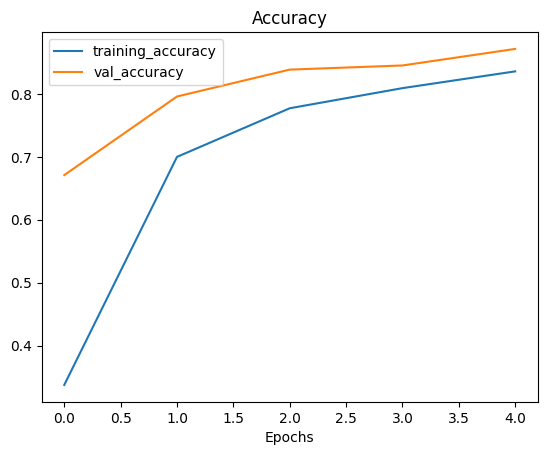

In [30]:
# Plot loss curves
plot_loss_curves(history_2_10_percent)

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful, so we can come and start where we left off.

In [31]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1) 

### Fit model 2 passing in the ModelCheckpoint callback

In [32]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          steps_per_epoch=len(train_data_10_percent),
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                 "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230403-072459
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.6572 - accuracy: 0.8453
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 428ms/step - loss: 0.6572 - accuracy: 0.8453 - val_loss: 0.5544 - val_accuracy: 0.8569
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.8373
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 414ms/step - loss: 0.6175 - accuracy: 0.8373 - val_loss: 0.5203 - val_accuracy: 0.8651
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.8680
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 657ms/step - loss: 0.5457 - accuracy: 0.8680 - val_loss: 0.4942 - val_accuracy: 0.8799
E

In [40]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.4942 - accuracy: 0.8632


In [34]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.5560 - accuracy: 0.8640


[0.5560497641563416, 0.8640000224113464]

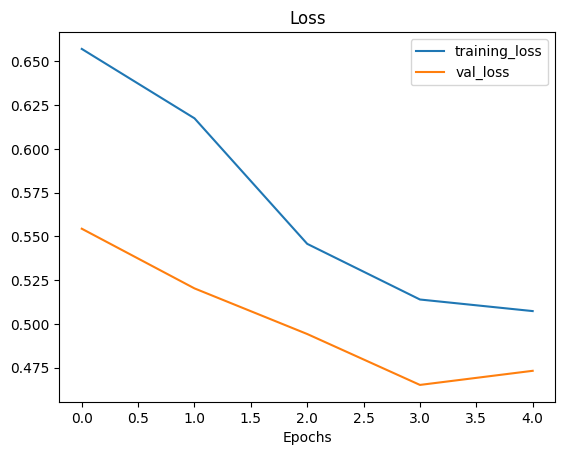

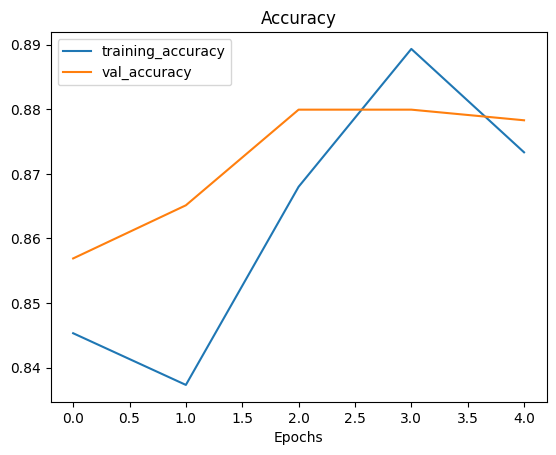

In [36]:
# Plot loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [37]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [38]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 101ms/step - loss: 0.4942 - accuracy: 0.8632


In [42]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

False

In [43]:
# Check to see if loaded model results are very close to previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [44]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


## Model 3: Fine tuning an existing model on 10% of the data

Fine-tuning usually works best *after* training a feature extraction model for a frew epochs with large amounts of custom data.

In [45]:
# Layers in loaded model
model_2.layers

In [46]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f554cf92430> True
<keras.engine.sequential.Sequential object at 0x7f555c0a95e0> True
<keras.engine.functional.Functional object at 0x7f554cd68d60> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f554cf60370> True
<keras.layers.core.dense.Dense object at 0x7f554cd6ecd0> True


In [50]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [52]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [54]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# When you start to fine-tune you typically lower learning rate by 10x
# Recompile (we have to recompile our modelw everytime we make a change)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [56]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [57]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there
print(len(model_2.trainable_variables))

12


In [59]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               steps_per_epoch=len(train_data_10_percent),
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                      "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230403-080654
Epoch 5/10
24/24 [==============================] - 24s 504ms/step - loss: 0.5622 - accuracy: 0.8147 - val_loss: 0.4398 - val_accuracy: 0.8651
Epoch 6/10
24/24 [==============================] - 9s 371ms/step - loss: 0.2290 - accuracy: 0.9320 - val_loss: 0.3853 - val_accuracy: 0.8750
Epoch 7/10
24/24 [==============================] - 8s 303ms/step - loss: 0.1629 - accuracy: 0.9573 - val_loss: 0.4792 - val_accuracy: 0.8536
Epoch 8/10
24/24 [==============================] - 10s 400ms/step - loss: 0.1331 - accuracy: 0.9533 - val_loss: 0.5437 - val_accuracy: 0.8421
Epoch 9/10
24/24 [==============================] - 9s 356ms/step - loss: 0.1004 - accuracy: 0.9707 - val_loss: 0.3559 - val_accuracy: 0.8832
Epoch 10/10
24/24 [==============================] - 10s 389ms/step - loss: 0.0934 - accuracy: 0.9747 - val_loss: 0.4292 - val_accuracy: 0.8816


In [61]:
# Evaluate on full test set
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 8s 92ms/step - loss: 0.5186 - accuracy: 0.8572


[0.5186218023300171, 0.857200026512146]

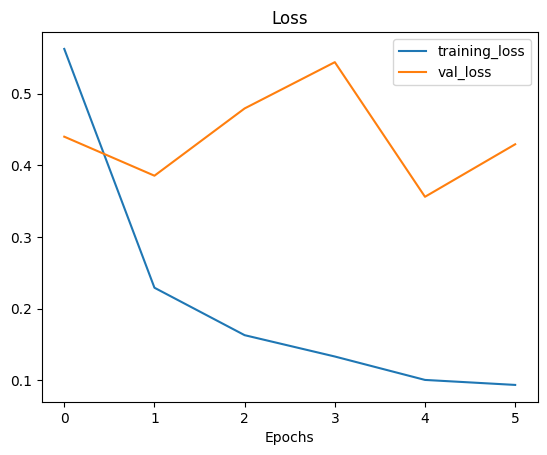

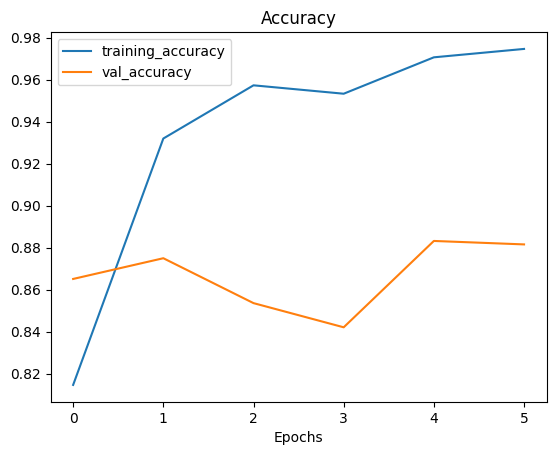

In [64]:
# Checkout the loss curves of our fine tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss-curves` function works great with models wchich have only been fit once, however, we want something to compare one history of running `fit()` with another (e.g. before and after fine-tuning) 

In [70]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects
  """

  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc +  new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine-tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine-tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Loss")

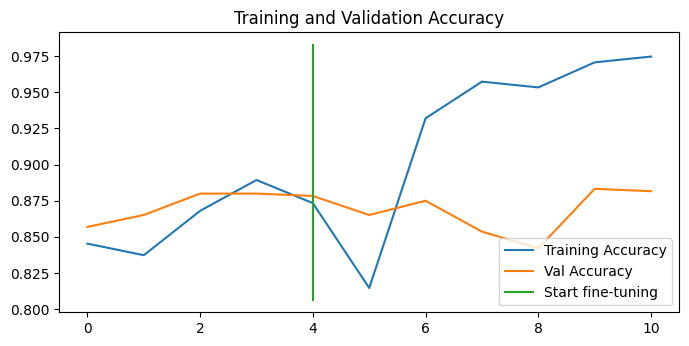

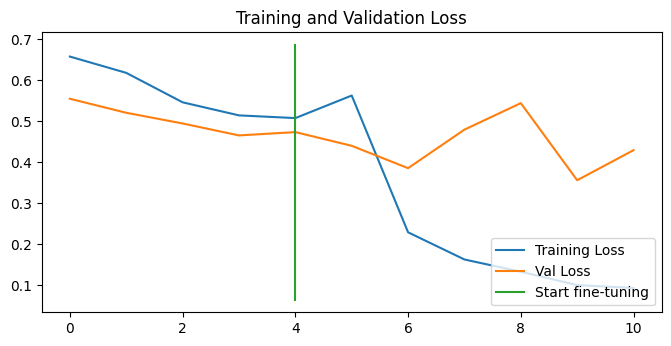

In [71]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug)

## Model 4: Fine-tuning an existing model on all of the data

In [ ]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

In [74]:
# Setup training and test dir
train_dir_all_data = "/content/10_food_classes_all_data/train/"
test_data = "/content/10_food_classes_all_data/test/"

In [75]:
# Setup data inputs
import tensorflow as tf
IMAGE_SIZE = (224, 224)

train_data_all = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                     image_size=IMAGE_SIZE,
                                                                     batch_size=32,
                                                                     label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_data,
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=32,
                                                                label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [81]:
# Setup the input shape and base model freezing the top layers
input_shape=(224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augumentation
x = data_augumentation(inputs)

# Give base model the inputs and dont train it
x = base_model(x, training=False)

# Pool output features out of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# Put out a Dense layer as an output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model
model_4 = tf.keras.Model(inputs, outputs)

In [85]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# When you start to fine-tune you typically lower learning rate by 10x
# Recompile (we have to recompile our modelw everytime we make a change)
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

To train a fine-tuning `model_4` we need to revert model_2 back to its feature extraction weights

In [86]:
model_4.load_weights(checkpoint_path)

In [89]:
# Recompile (we have to recompile our modelw everytime we make a change)
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

The test dataset we've loaded in is the same as waht we've been using fro previous experiments (all experiments have used the same test dataset)

Let's verify this...

In [87]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augumentation True
2 efficientnetb0 True
3 global_average_pooling True
4 output_layer True


In [88]:
# Let's drill into our base model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [76]:
# Evaluate model 2 (this is fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 92ms/step - loss: 0.5186 - accuracy: 0.8572


[0.5186217427253723, 0.857200026512146]

In [91]:
# Fine tune all data fit
history_fine_tune_all_data = model_4.fit(train_data_all,
                                         steps_per_epoch=len(train_dir_all_data),
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.25 * len(test_data)),
                                         callbacks=[create_tensorboard_callback("transfer_learning", "fine-tune-all-data")])

Saving TensorBoard log files to: transfer_learning/fine-tune-all-data/20230403-085659


Epoch 1/5
40/40 [==============================] - 23s 339ms/step - loss: 0.6527 - accuracy: 0.7859 - val_loss: 0.4028 - val_accuracy: 0.8701
Epoch 2/5
40/40 [==============================] - 12s 304ms/step - loss: 0.6388 - accuracy: 0.8000 - val_loss: 0.3588 - val_accuracy: 0.8734
Epoch 3/5
40/40 [==============================] - 12s 296ms/step - loss: 0.5773 - accuracy: 0.8109 - val_loss: 0.3729 - val_accuracy: 0.8684
Epoch 4/5
40/40 [==============================] - 10s 258ms/step - loss: 0.5848 - accuracy: 0.8086 - val_loss: 0.3161 - val_accuracy: 0.8882
Epoch 5/5
40/40 [==============================] - 11s 281ms/step - loss: 0.5911 - accuracy: 0.8086 - val_loss: 0.3564 - val_accuracy: 0.8783


In [92]:
# Evaluate the model
model_4.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.3532 - accuracy: 0.8852


[0.3532177209854126, 0.885200023651123]

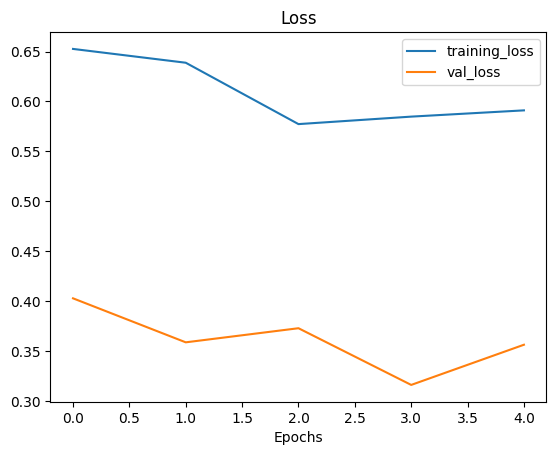

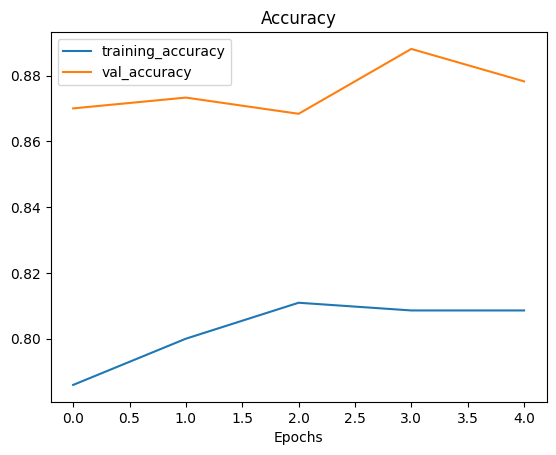

In [93]:
# Plot loss curves
plot_loss_curves(history_fine_tune_all_data)

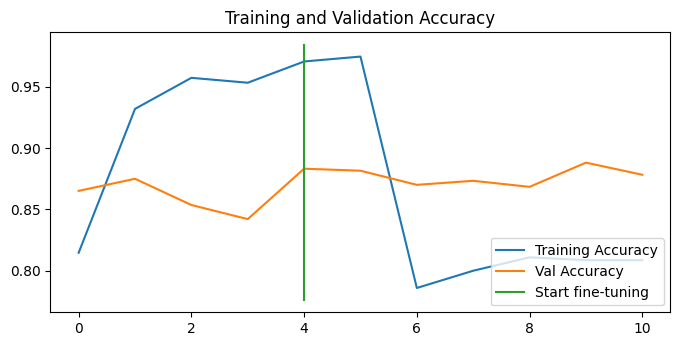

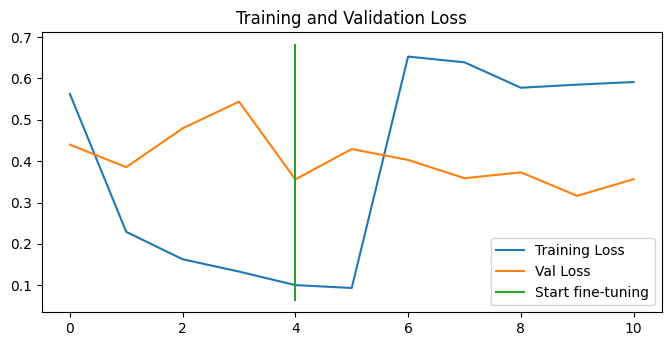

In [95]:
compare_historys(history_fine_10_percent_data_aug,
                 history_fine_tune_all_data)

## Viewing out experiment data on TensorBoard

In [98]:
# View tensorboard logs of transfer learning modelling experiments (~4 modelsl)
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning Experiments with 10 Food101 Classes" \
--description "A series of different transfer learning experiments with varying amount of data" \
--one_shot

2023-04-03 09:08:07.969215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   ZVR-BRY-WNQ



New experiment created. View your TensorBoard at: https://tensorboard.dev/

In [99]:
!tensorboard dev list

2023-04-03 09:14:04.008067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/dx4O8wGQSKegolyMdMoSGw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amount of data
	Id                   dx4O8wGQSKegolyMdMoSGw
	Created              2023-04-03 09:08:38 (5 minutes ago)
	Updated              2023-04-03 09:08:48 (5 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              156
	Tensor bytes         0
	Binary object bytes  4633449
https://tensorboard.dev/experiment/ymbJQszARr2rrHNLAmFk9Q/
	Name                 EfficientNetB0 vs. ResNet50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   ymbJQszARr2rrHNLAmFk9Q
	Created              2023-04-02 12:26:12 (20 hours ago)
	Updated     

In [100]:
# # To delete an experiment
# !tensorboard dev delete --experiment_id dx4O8wGQSKegolyMdMoSGw
# !tensorboard dev delete --experiment_id ymbJQszARr2rrHNLAmFk9Q
# !tensorboard dev delete --experiment_id 7RyLliDEQj6t0VxGoSprwQ

2023-04-03 09:14:45.370052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment dx4O8wGQSKegolyMdMoSGw.
2023-04-03 09:14:50.452893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment ymbJQszARr2rrHNLAmFk9Q.
2023-04-03 09:14:54.817098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment 7RyLliDEQj6t0VxGoSprwQ.
